In [1]:
# import libraries
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.special import digamma,gamma
import scipy.optimize as sciopt

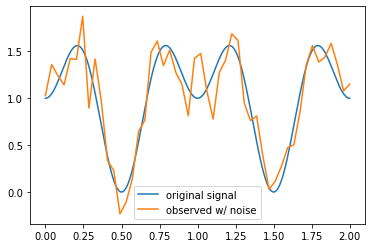

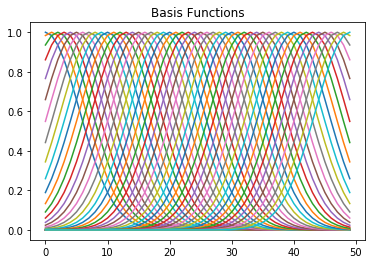

In [2]:
# Create basis for linear regression example

# set seed
np.random.seed(999)

# generate a signal
t = np.linspace(0,2,200)
x = np.sin(np.pi*t)**2 + np.sin(2*np.pi*t)**2 + np.cos(2*np.pi*t)

# create gaussian noise
var = 5e-2
n = np.random.normal(0,np.sqrt(var),50)

# get observations
t_obs = np.linspace(0,2,50)
y = x[0:200:4] + n

# plot original signal and signal w/ noise
plt.figure()
plt.plot(t,x,label='original signal')
plt.plot(t_obs,y,label='observed w/ noise')
plt.legend()
plt.show()

# generate basis functions
t_obs_mat = np.tile(t_obs[:,np.newaxis],(1,50))
ti_mat = t_obs_mat.T
X = np.exp(-(1/(2*var))*(t_obs_mat - ti_mat)**2)
plt.figure()
plt.plot(X)
plt.title('Basis Functions')
plt.show()

In [3]:
# Least Squares Estimate
w_ls = np.matmul(np.linalg.pinv(X),y)
y_ls = np.matmul(X,w_ls)
print(y_ls)

[ 1.02807274  1.35838176  1.24088834  1.16028756  1.34266729  1.6175806
  1.5317965   1.28186022  1.1630354   0.97629123  0.51578895  0.03057179
 -0.16395192 -0.07865257  0.14517123  0.50672838  0.98132255  1.37347131
  1.52781484  1.51871239  1.44217854  1.2678081   1.05580718  1.04316889
  1.27947489  1.41750307  1.1794491   0.87990393  1.03058442  1.54427576
  1.78277278  1.46084523  1.00667953  0.83231163  0.74168682  0.41673088
  0.06197548  0.07038116  0.3322258   0.4582901   0.51354218  0.86647034
  1.38415527  1.54910278  1.4019928   1.44828796  1.58508301  1.36972046
  1.08242798  1.15509033]


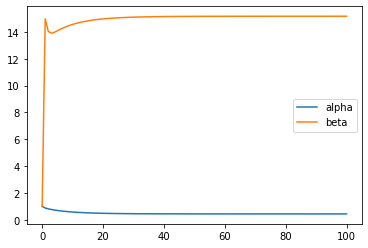

In [4]:
"""
    EM-based Bayesian Linear Regression
"""
# set sample and features
N = 50
M = 50
alpha = 1
beta = 20
a = list()
b = list()
a.append(alpha)
b.append(alpha)

# EM loop
for _ in range(100):
    # Expectation step
    sigma = np.linalg.inv(beta*np.matmul(X.T,X) + alpha*np.eye(N))
    mu = beta*np.matmul(sigma,np.matmul(X.T,y))

    # Maximization step
    alpha = M/(np.linalg.norm(mu)**2 + np.trace(sigma))
    beta = N/(np.linalg.norm(y-np.matmul(X,mu))**2 + np.trace(np.matmul(X.T,np.matmul(sigma,X))))

    # append to lists
    a.append(alpha)
    b.append(beta)
    
# plot alpha and beta
fig, ax = plt.subplots(1)
ax.plot(a, label='alpha')
ax.plot(b, label='beta')
ax.legend()
plt.show()

# set w_bem to mu (mean of posterior)
sigma = np.linalg.inv(beta*np.matmul(X.T,X) + alpha*np.eye(N))
mu = beta*np.matmul(sigma,np.matmul(X.T,y))
w_bem = mu

# calculate output
y_bem = np.matmul(X,w_bem)

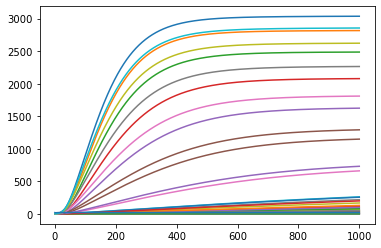

In [5]:
"""
    Variational EM-based Bayesian Linear Regression
"""
# set sample and features
N = 50
M = 50
Ealpha = np.ones((50,))
Ebeta = 20
a_list = list(); a_list.append(Ealpha)
b_list = list(); b_list.append(Ebeta)
a = 1e-6
b = 1e-6
c = 1e-6
d = 1e-6

# EM loop
for i in range(1000):
    # Expectation Step
    
    # Calc Mean and Variance
    sigma = np.linalg.inv(Ebeta*np.matmul(X.T,X) + np.diag(Ealpha))
    mu = Ebeta*np.matmul(sigma,np.matmul(X.T,y))

    # Maximization Step
    
    # calculate parameters
    a_tilde = a + 1/2
    b_tilde = b + (1/2)*(np.diag(sigma) + mu**2)
    c_tilde = c + N/2
    d_tilde = d + (1/2)*np.linalg.norm(y-np.matmul(X,mu))**2

    # calculate expected value of params (gamma distribution)
    Ealpha = a_tilde/b_tilde
    Ebeta = c_tilde/d_tilde

    # append to lists
    a_list.append(Ealpha)
    b_list.append(Ebeta)
    
# plot params_vec
a_list = np.vstack(a_list)
fig, ax = plt.subplots(1)
ax.plot(a_list)
ax.plot(b_list)
plt.show()

# get weights
sigma = np.linalg.inv(Ebeta*np.matmul(X.T,X) + np.diag(Ealpha))
mu = Ebeta*np.matmul(sigma,np.matmul(X.T,y))
w_vem = mu

# calculate output
y_vem = np.matmul(X,w_vem)

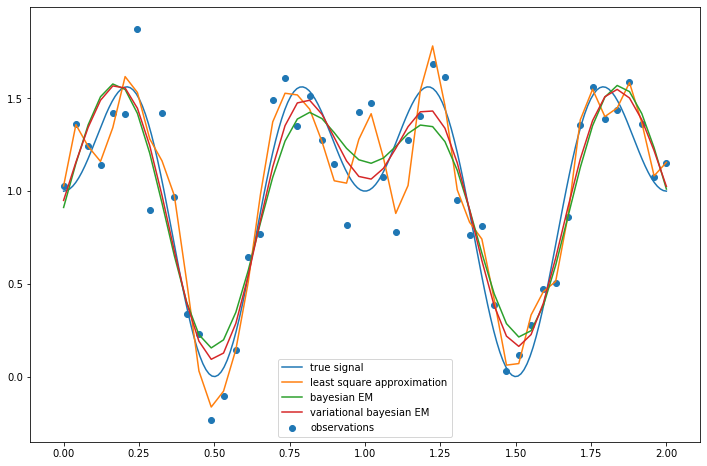

MSE (LS): 1.4833198249822321
MSE (Bayes): 0.7768291699582627
MSE (Variational Bayes): 0.4360061862647408


In [6]:
# plot outputs
fig, ax = plt.subplots(1,figsize=(12,8))
ax.plot(t, x, label='true signal')
ax.scatter(t_obs, y, label='observations')
ax.plot(t_obs, y_ls, label='least square approximation')
ax.plot(t_obs, y_bem, label='bayesian EM')
ax.plot(t_obs, y_vem, label='variational bayesian EM')
ax.legend()
plt.show()

# print MSE to true signal
mse_ls = np.linalg.norm(x[0:200:4] - y_ls)**2
mse_bem = np.linalg.norm(x[0:200:4] - y_bem)**2
mse_vem = np.linalg.norm(x[0:200:4] - y_vem)**2
print("MSE (LS): {}".format(mse_ls))
print("MSE (Bayes): {}".format(mse_bem))
print("MSE (Variational Bayes): {}".format(mse_vem))